In [1]:
import json
import pandas as pd

In [2]:
data = pd.read_json('mlp_profile.jsonl', lines=True)

In [3]:
q_forward = data[
    (data['input_dim'] == 4096) & (data['output_dim'] == 4096)
].groupby('context_length')['forward_time'].min()

q_backward = data[
    (data['input_dim'] == 4096) & (data['output_dim'] == 4096)
].groupby('context_length')['backward_time'].min()

k_forward = data[
    (data['input_dim'] == 1024) & (data['output_dim'] == 4096)
].groupby('context_length')['forward_time'].min()

k_backward = data[
    (data['input_dim'] == 1024) & (data['output_dim'] == 4096)
].groupby('context_length')['backward_time'].min()

o_forward = data[
    (data['input_dim'] == 4096) & (data['output_dim'] == 14336)
].groupby('context_length')['forward_time'].min()

o_backward = data[
    (data['input_dim'] == 4096) & (data['output_dim'] == 14336)
].groupby('context_length')['backward_time'].min()

mlp_gate_proj_forward = data[
    (data['input_dim'] == 14336) & (data['output_dim'] == 4096)
].groupby('context_length')['forward_time'].min()

mlp_gate_proj_backward = data[
    (data['input_dim'] == 14336) & (data['output_dim'] == 4096)
].groupby('context_length')['backward_time'].min()

mlp_up_proj_forward = data[
    (data['input_dim'] == 4096) & (data['output_dim'] == 14336)
].groupby('context_length')['forward_time'].min()

mlp_up_proj_backward = data[
    (data['input_dim'] == 4096) & (data['output_dim'] == 14336)
].groupby('context_length')['backward_time'].min()

mlp_down_proj_forward = data[
    (data['input_dim'] == 14336) & (data['output_dim'] == 4096)
].groupby('context_length')['forward_time'].min()

mlp_down_proj_backward = data[
    (data['input_dim'] == 14336) & (data['output_dim'] == 4096)
].groupby('context_length')['backward_time'].min()

In [4]:
forward_time = q_forward + 2 * k_forward + o_forward + mlp_gate_proj_forward + mlp_up_proj_forward + mlp_down_proj_forward 
backward_time = q_backward + 2 * k_backward + o_backward + mlp_gate_proj_backward + mlp_up_proj_backward + mlp_down_proj_backward 

In [5]:

dfw2 = pd.read_json('allreduce.w2.jsonl', lines=True)
dfw4 = pd.read_json('allreduce.w4.jsonl', lines=True)

In [6]:
tensor_size = [i * 4096 * 2 for i in forward_time.index.to_list()]
tensor_size_mb = [i / 1024 / 1024 for i in tensor_size]
tensor_size_mb

[0.5, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0]

In [7]:
tensor_size

[524288,
 4194304,
 8388608,
 16777216,
 33554432,
 67108864,
 134217728,
 268435456,
 536870912,
 1073741824,
 2147483648]

In [8]:
dfw2_filtered = dfw2[dfw2['tensor_size'].isin(tensor_size)].copy()
dfw2_filtered['context_length'] = dfw2_filtered['tensor_size'] / 4096 / 2
dfw2_filtered = dfw2_filtered[['context_length', 'mean_time_ms']]

In [31]:
attn_time = pd.read_csv('attn_time.csv')
attn_time_tp1cp1 = attn_time[
    (attn_time['tp_size'] == 1) & 
    (attn_time['cp_size'] == 1)
]
attn_time_tp1cp1 = attn_time_tp1cp1.groupby('context_length')['per_seq_latency'].min()
attn_time_tp1cp1


context_length
128        1.446256
256        1.422467
512        1.331298
1024       1.501970
2048       2.373690
            ...    
61440    562.887256
62464    581.426855
63488    600.173877
64512    619.256934
65536    638.616992
Name: per_seq_latency, Length: 67, dtype: float64

Text(0, 0.5, 'Time (ms)')

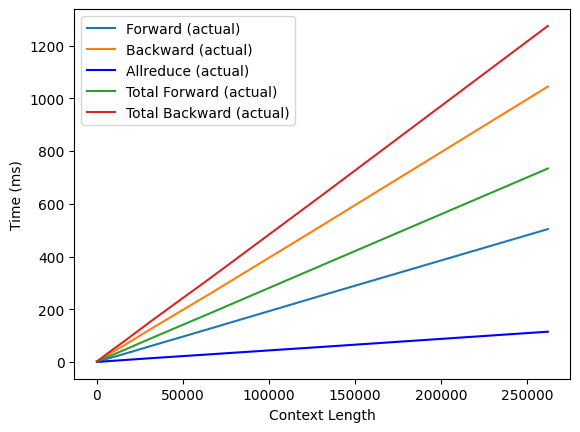

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate total time
total_forward_time = forward_time + 2 * dfw2_filtered.set_index('context_length')['mean_time_ms'] + attn_time_tp1cp1 / 3
total_backward_time = backward_time + 2 * dfw2_filtered.set_index('context_length')['mean_time_ms'] + attn_time_tp1cp1 / 3 * 2

# Fit linear function for total time
forward_coef = np.polyfit(forward_time.index, forward_time.values, 1)
backward_coef = np.polyfit(backward_time.index, backward_time.values, 1)
allreduce_coef = np.polyfit(dfw2_filtered['context_length'], dfw2_filtered['mean_time_ms'], 1)
total_coef = np.polyfit(total_forward_time.index, total_forward_time.values, 1)
forward_linear = np.poly1d(forward_coef)
backward_linear = np.poly1d(backward_coef)
allreduce_linear = np.poly1d(allreduce_coef)
total_linear = np.poly1d(total_coef)

# Plot original data
forward_time.plot(label='Forward (actual)')
backward_time.plot(label='Backward (actual)')
plt.plot(dfw2_filtered['context_length'], dfw2_filtered['mean_time_ms'], 'b-', 
         label='Allreduce (actual)')
total_forward_time.plot(label='Total Forward (actual)')
total_backward_time.plot(label='Total Backward (actual)')


# # Plot linear approximations
# plt.plot(forward_time.index, forward_linear(forward_time.index), '--', 
#          label=f'Forward (linear): {forward_coef[0]:.2e}x + {forward_coef[1]:.2e}')
# plt.plot(backward_time.index, backward_linear(backward_time.index), '--',
#          label=f'Backward (linear): {backward_coef[0]:.2e}x + {backward_coef[1]:.2e}')
# plt.plot(dfw2_filtered['context_length'], allreduce_linear(dfw2_filtered['context_length']), 'b--',
#          label=f'Allreduce (linear): {allreduce_coef[0]:.2e}x + {allreduce_coef[1]:.2e}')
# plt.plot(total_forward_time.index, total_linear(total_forward_time.index), '--',
#          label=f'Total Forward (linear): {total_coef[0]:.2e}x + {total_coef[1]:.2e}')
# plt.plot(total_backward_time.index, total_linear(total_backward_time.index), '--',
#          label=f'Total Backward (linear): {total_coef[0]:.2e}x + {total_coef[1]:.2e}')

plt.legend()
plt.xlabel('Context Length')
plt.ylabel('Time (ms)')